In [4]:
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
from scipy.signal import convolve2d
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd

np.set_printoptions(precision=3, suppress=True)

import time
from matplotlib.colors import ListedColormap

# smooth thing with convolutions and fractional populations; doesn't do cycles

In [70]:
N = 300
nCell = 1
nNeighbors = 8
nSpecies = 7

initDistribution = np.random.uniform(size = nSpecies*N*N)

initField = nCell * initDistribution.reshape(nSpecies,N,N)
growthRates = np.array(nSpecies*[0.2]) 

deathRates = np.array(nSpecies*[0.6])
boost = 0
boostRates = np.eye(nSpecies)
for a in range(nSpecies-1):
    boostRates[a, a+1] = boost
boostRates[nSpecies-1,0] = boost

boostRates

    
def getDominantSpeies(field):
    return np.argsort(field,axis = 0, )[-1,:,:]

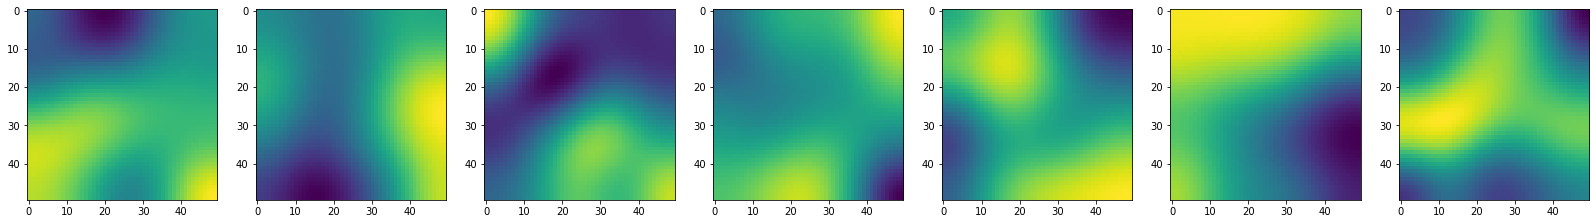

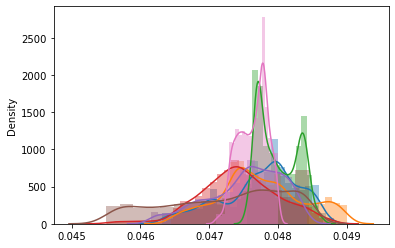

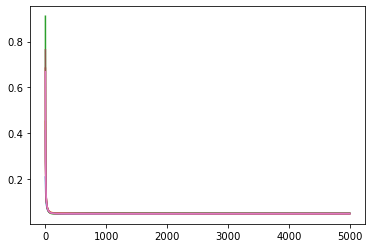

In [68]:
nSteps = 5000

fields = [initField]

for n in range(nSteps):
    field = fields[-1]
    newField = np.zeros((nSpecies,N,N))
    
    filt = np.ones((3,3)) / nNeighbors # sum up all neighbors of the same species
    for i in range(nSpecies):
        newField[i] = convolve2d(field[i,:,:], filt, mode = "same") 
        
    growth = np.einsum('ij,jkl->jkl', 
                       boostRates, 
                       newField / newField.sum(axis=0) # growth boost should be normalized
                      ) * growthRates[:,None, None] 
    death = deathRates[:,None,None]
   # print(np.sum(field*growth), np.sum(field*death))
    newField = field + field * growth - field**2 * death
   # newField /= np.sum(field, axis = 0)
    np.place(newField, newField < 0, 0)
    fields.append(newField)
    
    
%matplotlib inline

fig, ax = plt.subplots(1,nSpecies, figsize = (4*nSpecies,4))
for i in range(nSpecies):
    ax[i].imshow(fields[-1][i])
plt.show()

for a in range(nSpecies):
    sns.distplot(fields[-1][a].flatten())   
plt.show()

for i in range(nSpecies):
    plt.plot([f[i,1,1] for f in fields])

<IPython.core.display.Javascript object>


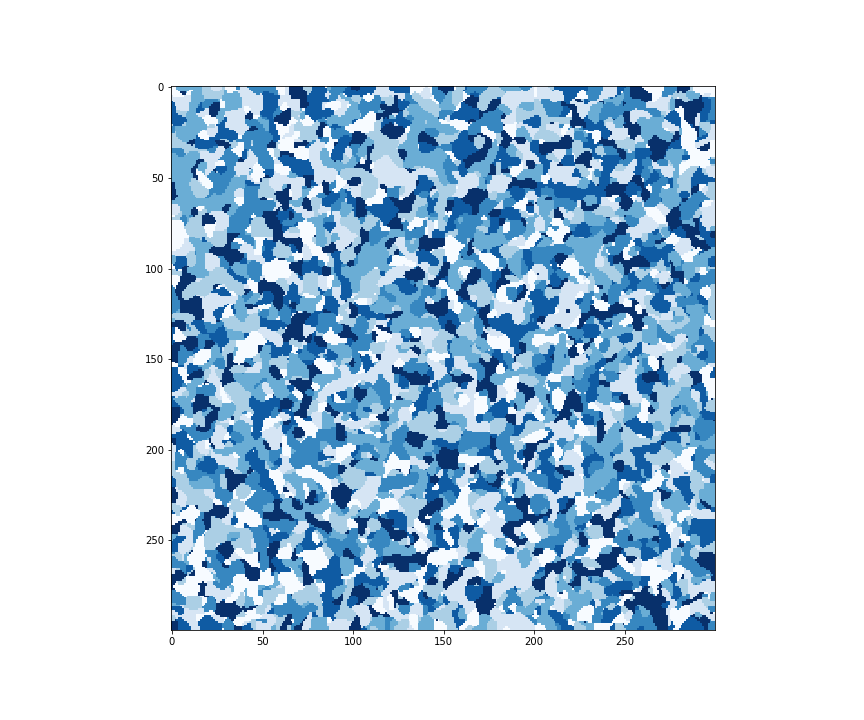

In [71]:
%matplotlib notebook

fig, ax = plt.subplots(figsize = (12,10))

im=plt.imshow(getDominantSpeies(initField),
             # interpolation='none', 
              interpolation='none', 
              cmap = "Blues")

field = initField
# initialization function: plot the background of each frame
def init():
    im.set_data(getDominantSpeies(field))
    return [im]

# animation function.  This is called sequentially
step = 1
def animate(i):
    global field
    newField = np.zeros((nSpecies,N,N))
    
    filt = np.ones((3,3)) / nNeighbors # sum up all neighbors of the same species
    for i in range(nSpecies):
        newField[i] = convolve2d(field[i,:,:], filt, mode = "same") 
        
    growth = np.einsum('ij,jkl->jkl', 
                       boostRates, 
                       newField / newField.sum(axis=0) # growth boost should be normalized
                      ) * growthRates[:,None, None] 
    death = deathRates[:,None,None]
   # print(np.sum(field*growth), np.sum(field*death))
    newField = field + field * growth - field**2 * death
   # newField /= np.sum(field, axis = 0)
    np.place(newField, newField < 0, 0)
    field = newField
    if i % step == 0:
        im.set_array(getDominantSpeies(field))
    return [im]

ani = FuncAnimation(fig, animate, frames=nSteps, interval=1, 
                    init_func=init, blit=True)
plt.show()

### hypercycles based off 
Boerlijst, Maarten C., and Paulien Hogeweg. "Spiral wave structure in pre-biotic evolution: hypercycles stable against parasites." Physica D: Nonlinear Phenomena 48.1 (1991): 17-28.

# a slow nested version

In [6]:
def north(i, j):
    j -= 1
    return i, pbc(j), 0, -1

def east(i, j):
    i += 1
    return pbc(i), j, 1, 0

def south(i, j):
    j += 1
    return i, pbc(j), 0, 1

def west(i, j):
    i -= 1
    return pbc(i), j, -1, 0

deltas = [[0,-1],[1,0],[0,1],[-1,0],]

directions = [north, east, south, west]

def pbc(x):
    global N
    if x >= N:
        return x - N 
    if x < 0:
        return x + N
    else: return x
    
    
    
filtersNWSE = [ # replicate from that direction
    [[0,0,0],[0,0,0],[0,1,0]], # N
    [[0,0,0],[1,0,0],[0,0,0]], # E
     [[0,1,0],[0,0,0],[0,0,0]], # S
    [[0,0,0],[0,0,1],[0,0,0]], # W
]

filtersBoost = [
    [[1,0,1],
     [1,0,1],
     [0,0,0]], # N
    [[1,1,0],
     [0,0,0],
     [1,1,0]], # W
    [[0,0,0],
     [1,0,1],
     [1,0,1]], # S
    [[0,1,1],
     [0,0,0],
     [0,1,1]], # E
]
N = 75

pDeath = 0.1
wDead = 5
wBoost = 100


nSpecies = 9
sMax = 6
speciesIdList = range(1, nSpecies + 1) # or have them from 0 to nSpecies to init with empty
speciesIds = np.arange(1, nSpecies+1, dtype = int)

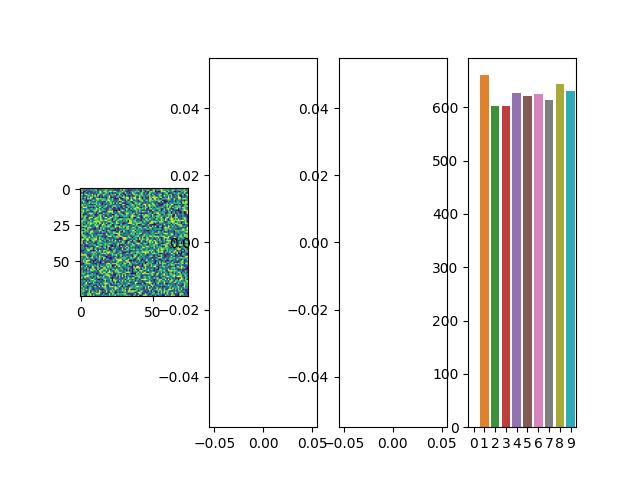

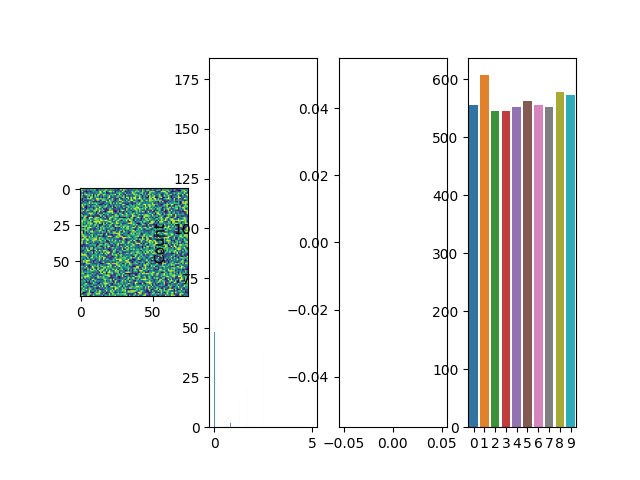

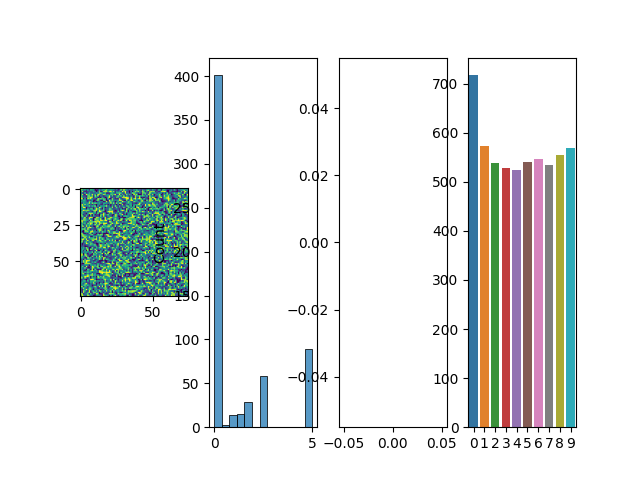

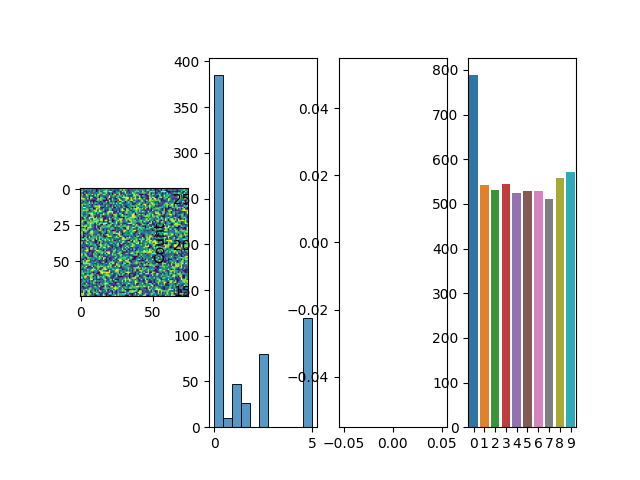

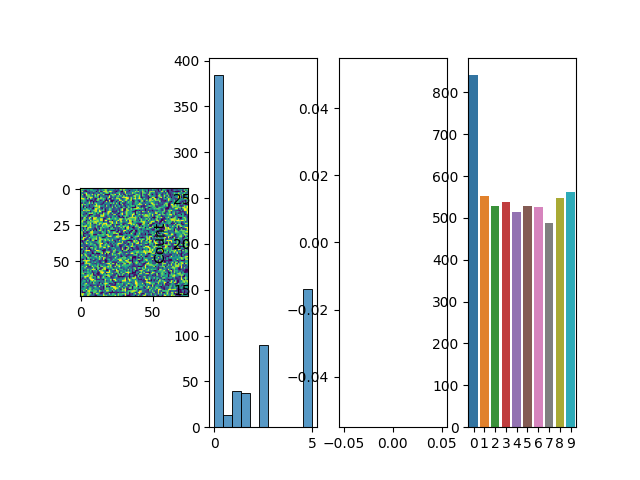

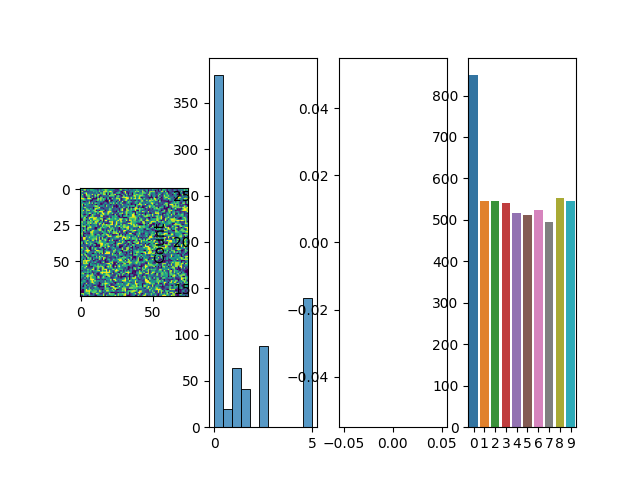

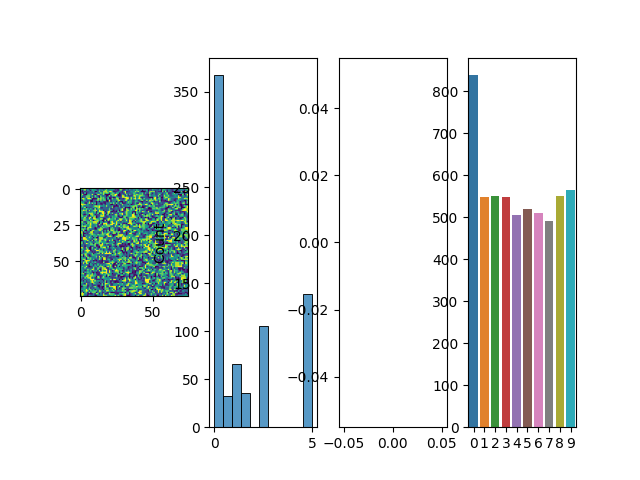

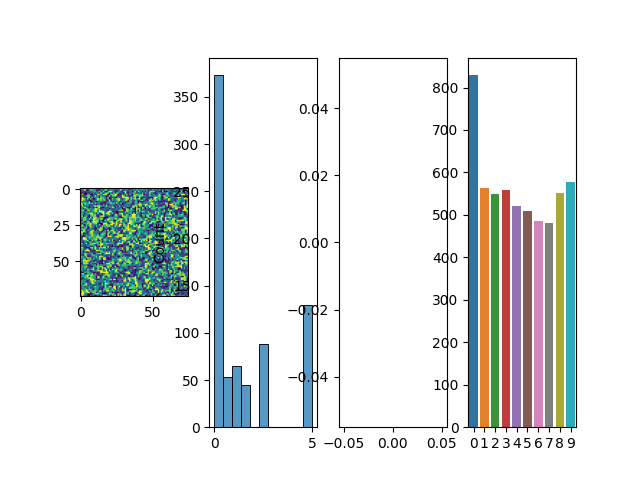

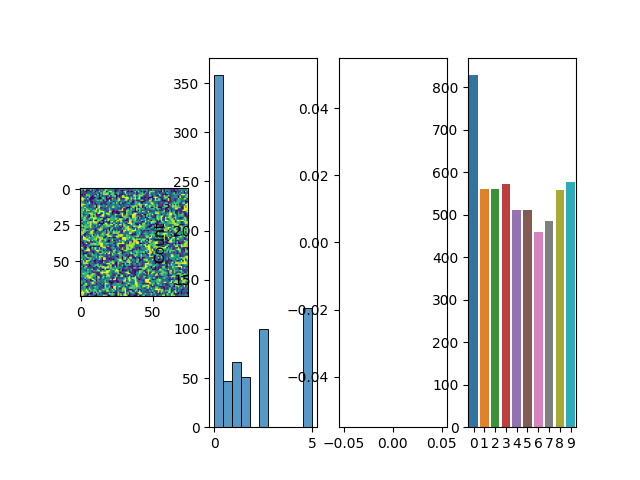

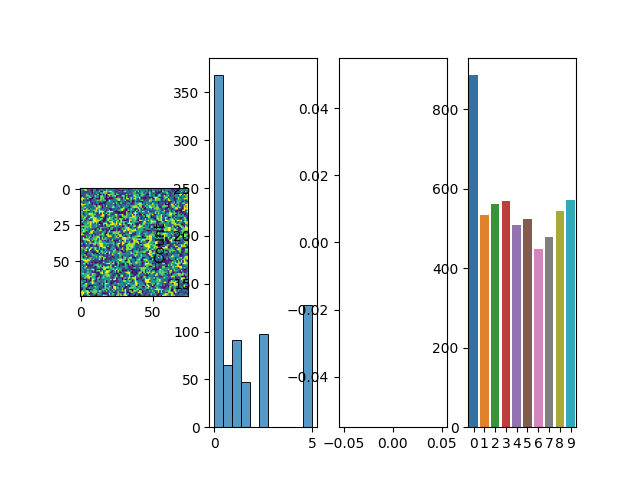

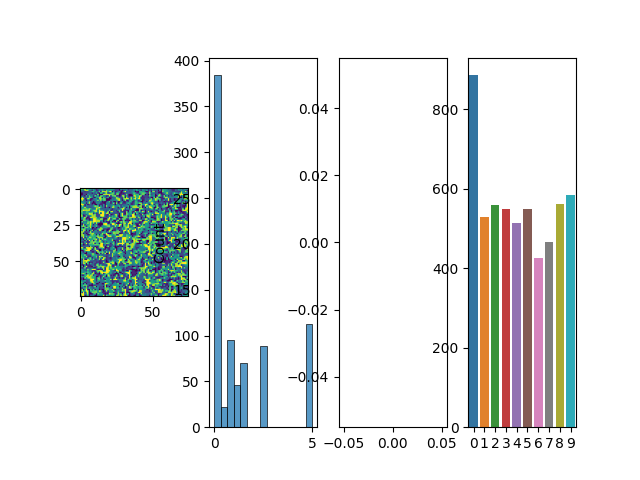

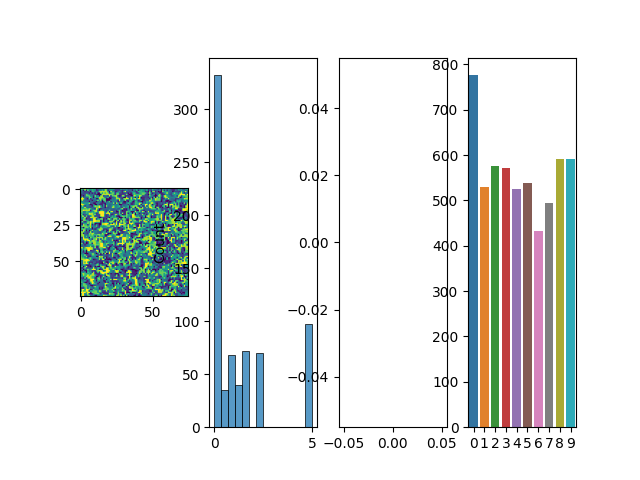

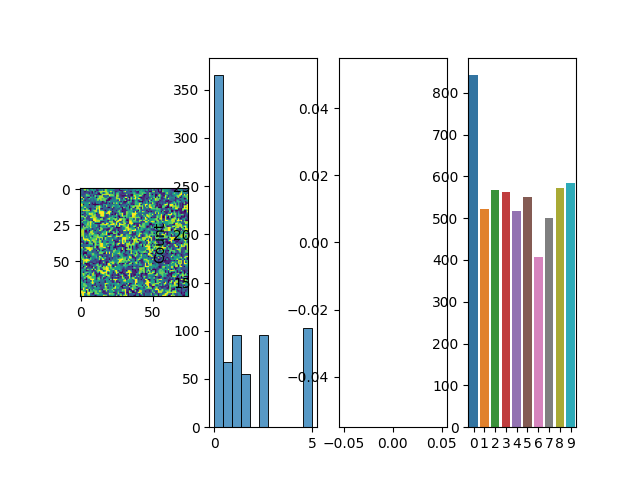

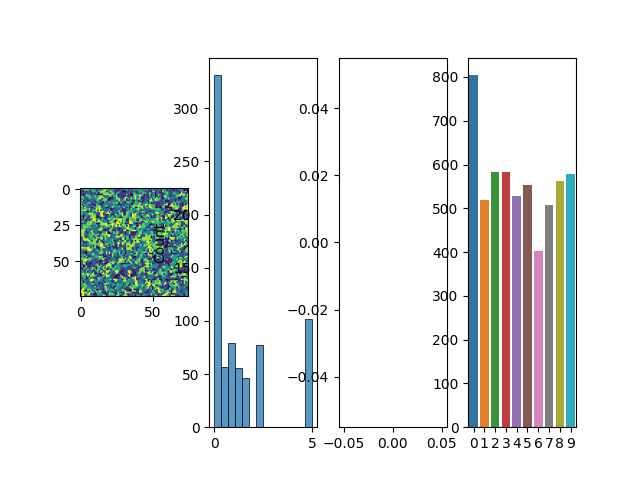

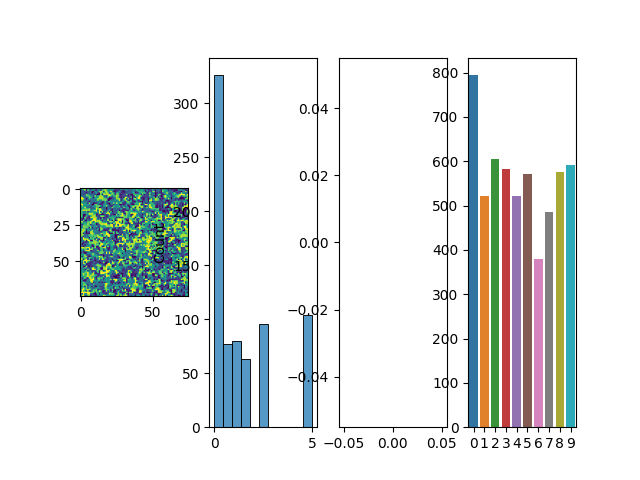

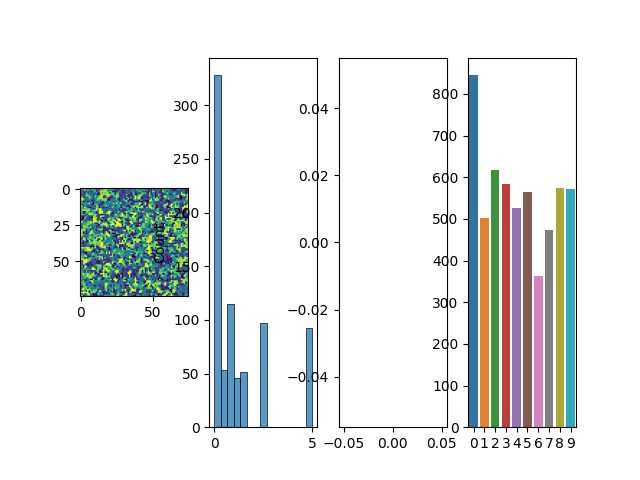

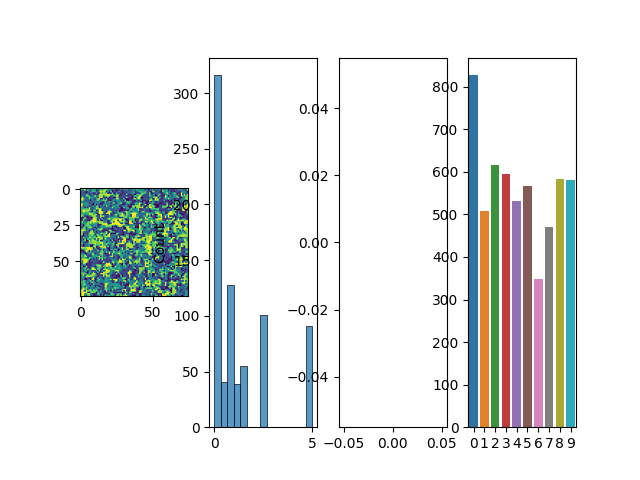

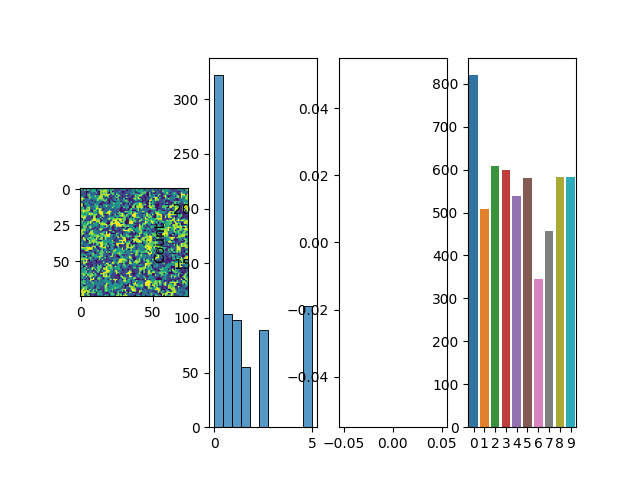

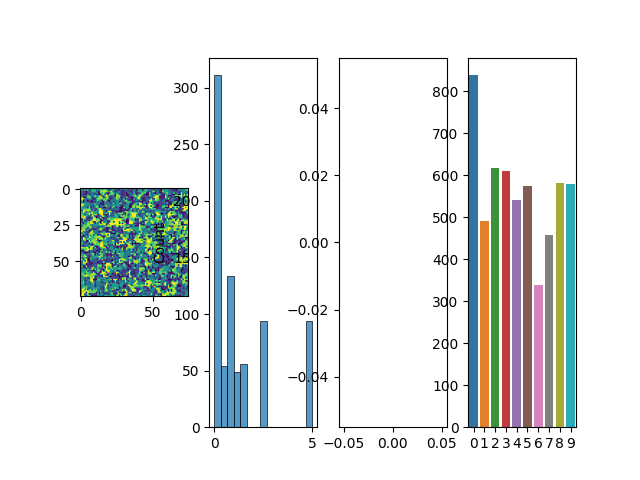

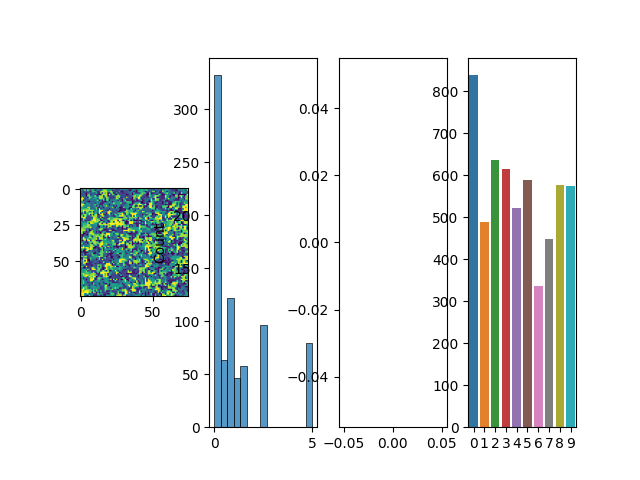

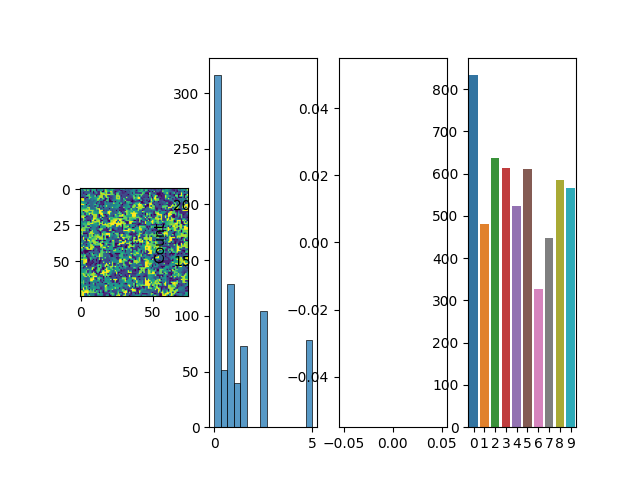

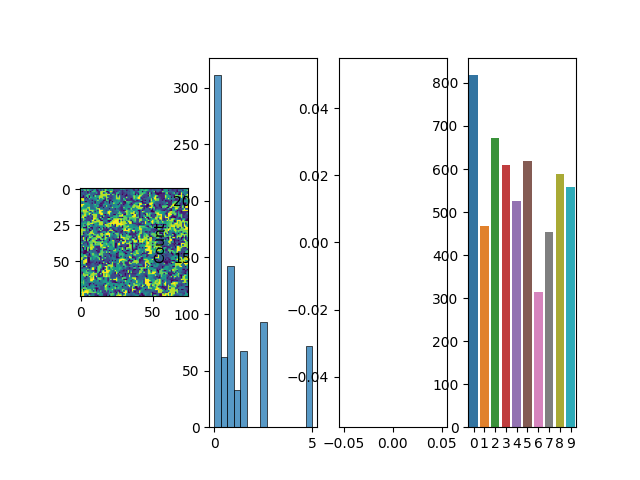

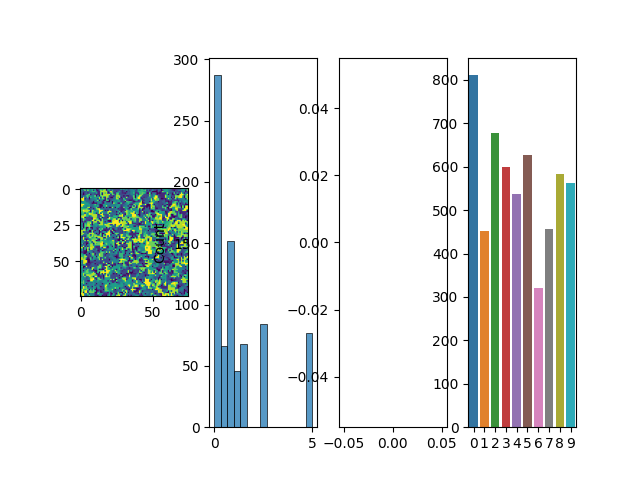

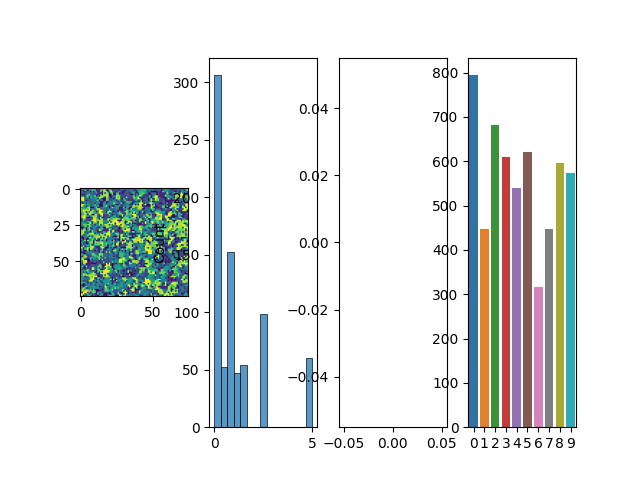

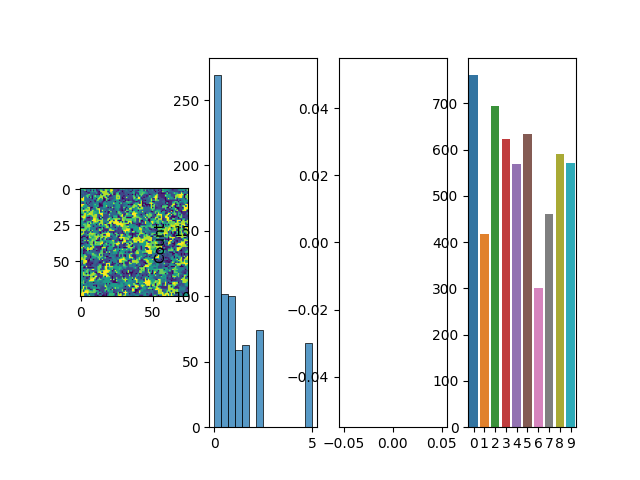

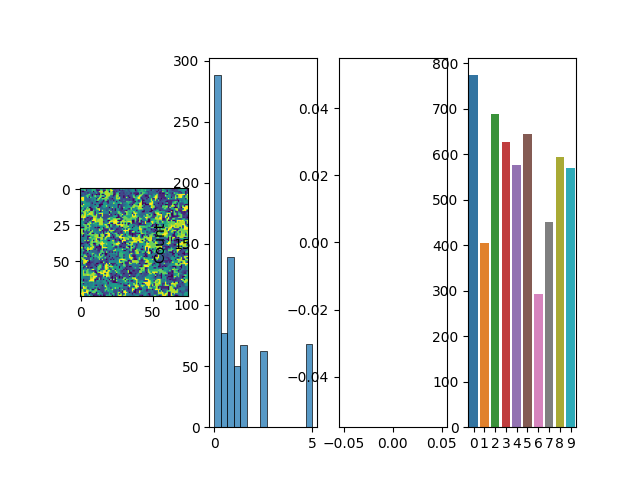

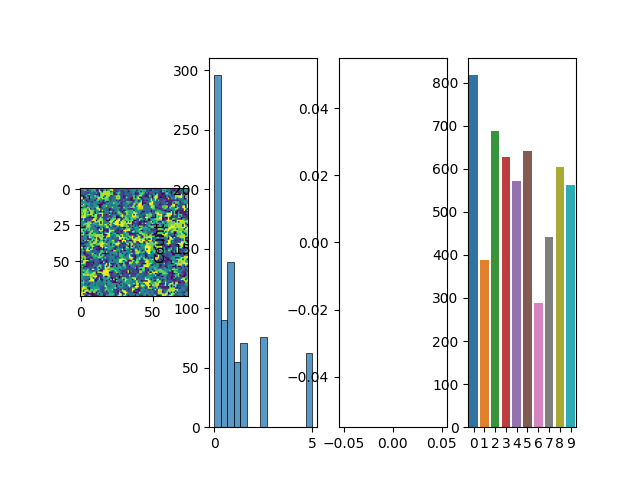

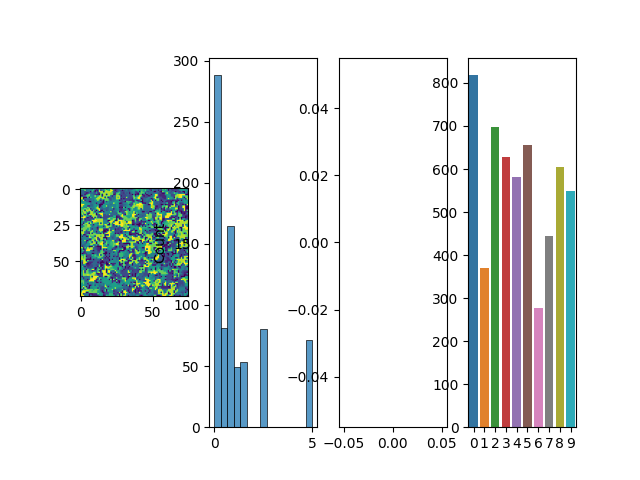

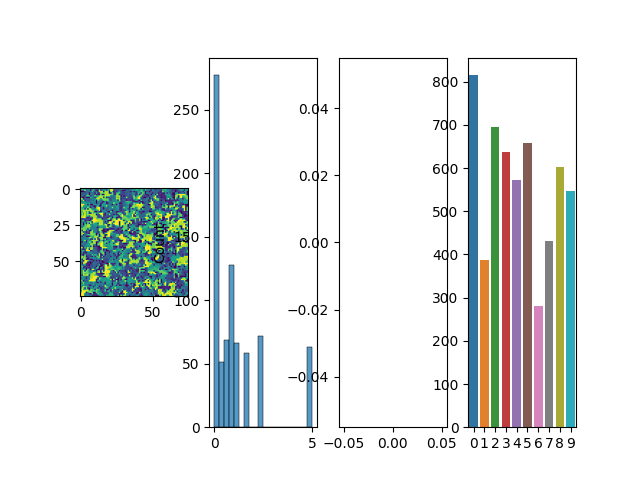

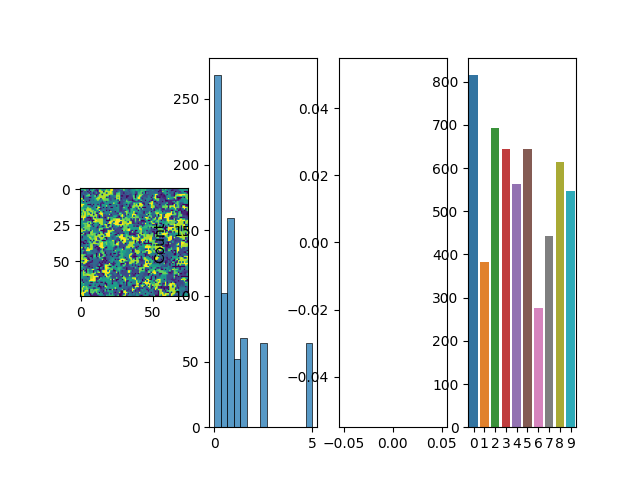

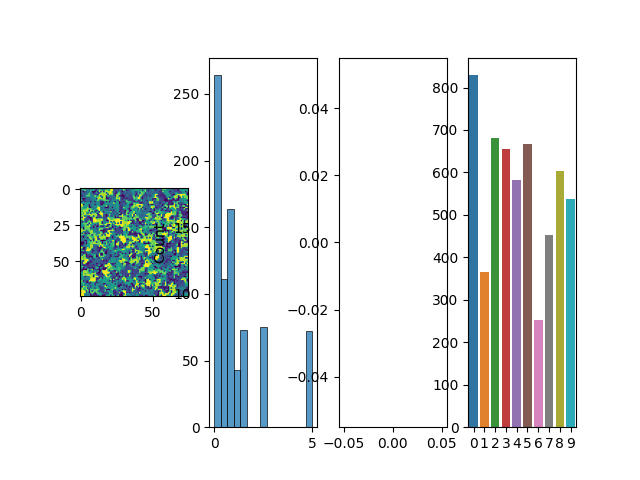

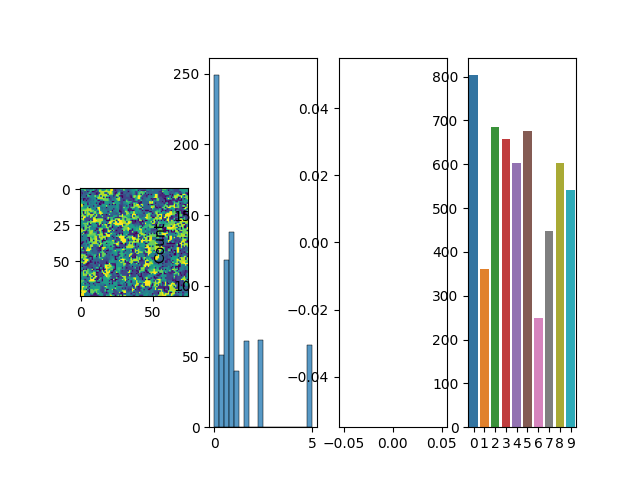

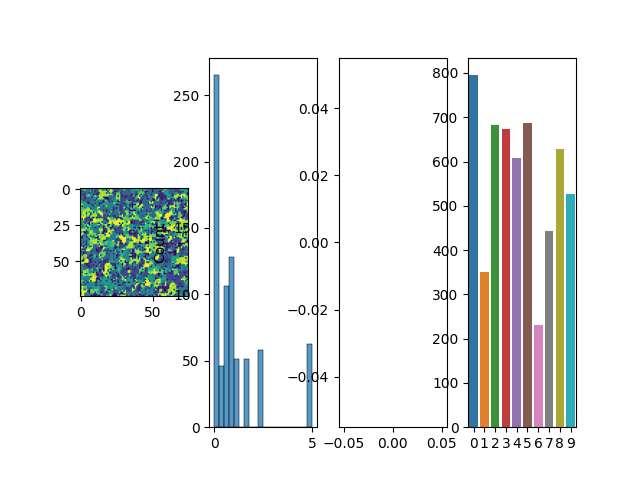

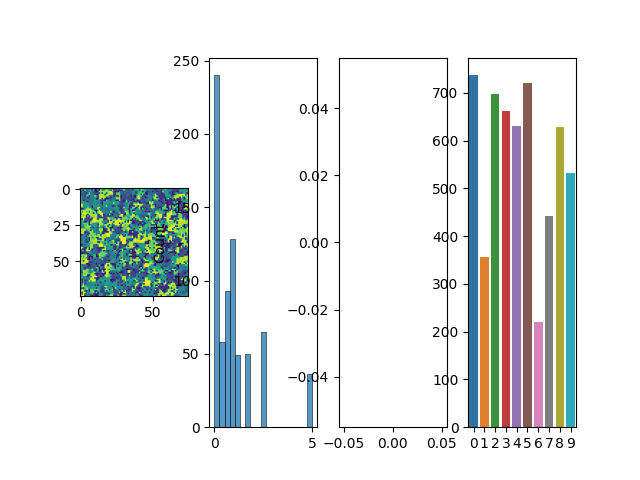

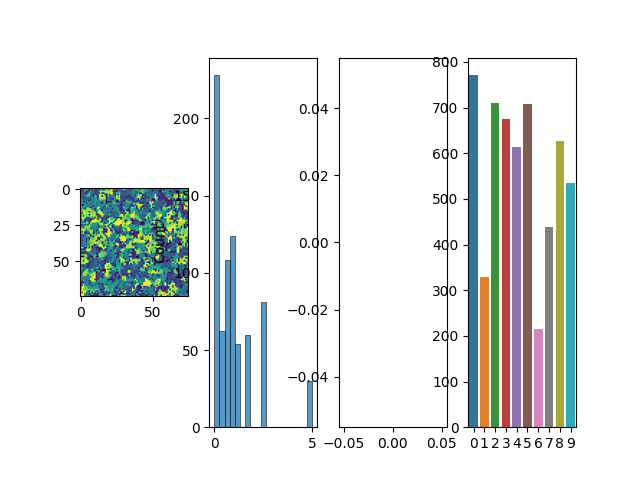

KeyboardInterrupt: 

In [8]:
%matplotlib ipympl

lattice = np.zeros((nSpecies+1,N,N), dtype = int)
initDistribution = np.random.choice(speciesIdList, size = N*N)
initLattice = initDistribution.reshape(N,N)
for s in range(1,nSpecies+1):
    lattice[s][initLattice == s] = 1



nSteps = 250

trs = []
cfs = []
frs = []
pops = []
boosts = []
for t in range(nSteps):    
    newLattice = np.zeros((nSpecies+1, N, N), dtype = int)
    latticeFlat = (lattice[1:, :, :] * speciesIds[:,None,None]).sum(axis = 0)
    totalReplications = 0
    crowdedFails = 0
    boosts = []
    for i in range(N):
        for j in range(N):

            s = latticeFlat[i, j] # the id of species in i, j
            
            if s == 0: continue # already dead

            # replication
            if np.random.uniform() >= pDeath:
                newLattice[s, i, j] = 1 # survived
                
                # try replicate into empty cells
                empty = np.array([
                    latticeFlat[north(i, j)[:2]] == 0,
                    latticeFlat[east (i, j)[:2]] == 0,
                    latticeFlat[south(i, j)[:2]] == 0,
                    latticeFlat[west (i, j)[:2]] == 0,
                ])
                
                if empty.sum() > 0:
                    
                    sPrev = s - 1 # boost comes from the previous species
                    if sPrev == 0: sPrev = nSpecies - 2 # correct booster idx for the first species
                    if sPrev > sMax: sPrev = sMax    
                    emptyDirectons = np.where(empty != 0)[0]
                    #randomEmpty = np.random.choice(emptyDirectons)
                    for randomEmpty in emptyDirectons:
                        iNew, jNew, dI, dJ = directions[randomEmpty](i, j)

                        nBoost = wBoost * np.sum([ # "any of the four neigbors"
                                lattice[sPrev, pbc(iNew + dJ), pbc(jNew + dI)],
                                lattice[sPrev, pbc(iNew - dJ), pbc(jNew - dI)],
                                lattice[sPrev, pbc(i + dJ), pbc(j + dI)],
                                lattice[sPrev, pbc(i - dJ), pbc(j - dI)]])\
                                + np.sum([lattice[s, pbc(iNew + dJ), pbc(jNew + dI)],
                                lattice[s, pbc(iNew - dJ), pbc(jNew - dI)],
                                lattice[s, pbc(i + dJ), pbc(j + dI)],
                                lattice[s, pbc(i - dJ), pbc(j - dI)],])
                        

                        newLattice[s][iNew, jNew] += nBoost # accumulate claims
                       # boosts.append(nBoost)
                else:
                    crowdedFails += 1
           # else:
           #     print("died")
    
    # resolve claims
    failedReplications = 0
    ps = []
    for i in range(N):
        for j in range(N):
            if latticeFlat[i,j] == 0:
                col = newLattice[1:,i,j] # examine species only
                if col.sum() == 0: # all dead, no claims
                #    print("all dead, no claims")
                    continue
                w = np.hstack([wDead, col])
                p = w / sum(w)
                ps.append(p[0] / sum(p[1:]))
                winningReplicator = np.random.choice(range(nSpecies+1), p = p)
                if winningReplicator == 0: # remain empty
                    newLattice[:,i,j] = 0
                    failedReplications += 1
                  #  print("dead won")
                    continue
                newLattice[:,i,j] = 0
                newLattice[winningReplicator,i,j] = 1        
                totalReplications += 1
    lattice = newLattice
    
    trs.append(totalReplications)
    cfs.append(crowdedFails)
    frs.append(failedReplications)
    pops.append(newLattice.sum())
    
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(latticeFlat)
    sns.histplot(ps, ax =ax[1])
    sns.histplot(boosts, ax =ax[2])
    ccc = Counter(latticeFlat.flatten())
    ccc2 = {}
    for s in range(nSpecies+1):
        if s in ccc:
            ccc2[s] = ccc[s]
        else:
            ccc2[s] = 0
    sns.barplot(data = pd.DataFrame(ccc2, 
                index = [0]),
                    order = range(nSpecies+1), ax = ax[3])
    plt.show()
    
    # diffusion            
#     for i in range(N):
#         for j in range(N):
#             if newLattice[i, j] == 0: continue
            
            
                
        

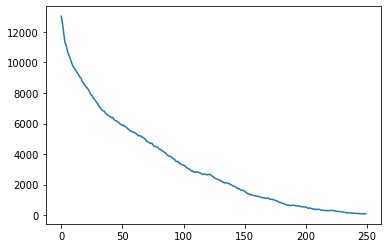

In [160]:
plt.plot(pops)

<IPython.core.display.Javascript object>


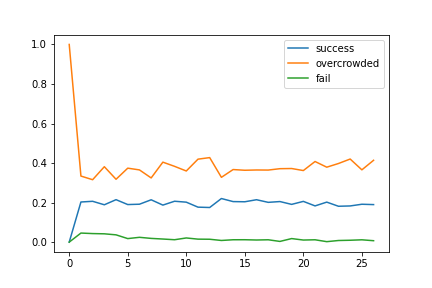

In [215]:
plt.plot([t/pp for t,pp in zip(trs,pops)], label = "success")
plt.plot([f/pp for f,pp in zip(cfs,pops)], label = "overcrowded")
plt.plot([f/pp for f,pp in zip(frs,pops)], label = "fail")
plt.legend()

In [4]:
%matplotlib notebook
timerPresicion = 5
filtersNWSE = [ # replicate from that direction
    [[0,0,0],[0,0,0],[0,1,0]], # N
    [[0,0,0],[1,0,0],[0,0,0]], # E
     [[0,1,0],[0,0,0],[0,0,0]], # S
    [[0,0,0],[0,0,1],[0,0,0]], # W
]

filtersBoost = [
    [[1,0,1],
     [1,0,1],
     [0,0,0]], # N
    [[1,1,0],
     [0,0,0],
     [1,1,0]], # W
    [[0,0,0],
     [1,0,1],
     [1,0,1]], # S
    [[0,1,1],
     [0,0,0],
     [0,1,1]], # E
]
N = 300

pDeath = 0.5
wDead = 5
wRepl = 5
wBoost = 100
nSteps = 50

nSpecies = 7

speciesIds = np.arange(nSpecies+1, dtype = int)

lattice = np.zeros((nSpecies+1,N,N), dtype = int)
initDistribution = np.random.choice(speciesIds[1:], size = N*N)
initLattice = initDistribution.reshape(N,N)


Rsq = N**2/2/np.pi 
seedIs = []
seedJs = []
for i in range(N):
    for j in range(N):
        if (N/2 - i)**2 + (N/2 - j)**2 > Rsq:
            seedIs.append(i)
            seedJs.append(j)

initLattice[seedIs,seedJs] = 0 
newLattice = np.zeros((nSpecies+1, N, N), dtype = int) # init global


for s in range(1,nSpecies+1):
    lattice[s][initLattice == s] = 1

for step in range(nSteps):
    timers = {}
    start = time.time()


    latticeFlat = (lattice * speciesIds[:,None,None]).sum(axis = 0)
    emptyCells = latticeFlat == 0
    fullCells = latticeFlat != 0
    r = np.random.random((N,N))

    survivorIds = np.bitwise_and(fullCells, (r >= pDeath))
    diedIds = np.bitwise_and(fullCells, (r < pDeath))
    ############################
    # get claims
    ############################
    start = time.time()

    # replication claims
    claims = np.zeros((nSpecies+1,N,N))
    claims[0] = wDead
    claimIters = []
    for s in range(1, nSpecies + 1):
        sBoost = s - 1
        if sBoost == 0: sBoost = nSpecies # dead don't boost
            
        start2 = time.time()

        for fNWSE, fBoost in zip(filtersNWSE, filtersBoost):
            tmpClaim = convolve2d(lattice[s], fNWSE, # get replication from the specific direction
                                  mode = "same", 
                                  boundary = "wrap")
            claims[s] += wRepl * tmpClaim
            allBoosts = convolve2d(lattice[sBoost], fBoost, # count boosts in all cells
                                   mode = "same", 
                                   boundary = "wrap")
            claims[s] += wBoost * (allBoosts * tmpClaim) # apply boosts only to potentially replicated cells
            
        stop2 = time.time()
    claimIters.append(stop2 - start2)
    
    
    stop = time.time()
    timers["claims"] = np.round(stop - start, 
                                timerPresicion)
    timers["claim iter"] = np.round(np.mean(claimIters),timerPresicion)

    # sample along species axis
    start = time.time()
    
    cumClaims = np.cumsum(claims / claims.sum(axis=0), axis=0)
    rand = np.random.random((N,N))
    newLatticeFlat = np.argmax(cumClaims >= rand, axis=0)

    # put everything together
    newLatticeFlat[survivorIds] = latticeFlat[survivorIds] # survivors shouldn't have been claimed
    newLatticeFlat[diedIds] = 0 # those died off

    newLattice = np.zeros((nSpecies+1, N, N), dtype = int)    
    for s in range(1, nSpecies+1):
        newLattice[s][newLatticeFlat == s] = 1   
    lattice = newLattice.copy()
    stop = time.time()
    timers["combine"] = np.round(stop - start, timerPresicion)
    
    

    im.set_array(newLatticeFlat)
    
    ccc = Counter(newLatticeFlat.flatten())
    for s in range(nSpecies+1):
        if not s in ccc:
            ccc[s] = 0
        
    vvv = [v for k,v in sorted([(k,v) for k,v in ccc.items()])]
    for rect, h in zip(im2, vvv):
        rect.set_height(h)
    ax[1].set_ylim(0, 1.05*max(vvv))
    stop = time.time()
    ax[0].set_title(timers)
    
    timer = np.round(stop - start, 3)
    print(timer)

NameError: name 'im' is not defined

### vectorized with scipy convolve2d; suboptimal

In [41]:
filtersNWSE = [ # replicate from that direction
    nSpecies*[[0,0,0],[0,0,0],[0,1,0]], # N
    nSpecies*[[0,0,0],[1,0,0],[0,0,0]], # E
    nSpecies*[[0,1,0],[0,0,0],[0,0,0]], # S
    nSpecies*[[0,0,0],[0,0,1],[0,0,0]], # W
]
filtersNWSE = np.array(filtersNWSE).reshape(4,nSpecies, 3, 3)

In [42]:
filtersNWSE.shape

(4, 9, 3, 3)

In [47]:
from scipy.ndimage import convolve as ndconvolve
asd = ndconvolve(lattice, filtersNWSE[0], # get replication from the specific direction
                                  mode = "wrap", 
                                  )

In [51]:

plt.imshow(asd.sum(axis = 0))

In [59]:
from scipy.ndimage import convolve as ndconvolve
filtersNWSE = [ # replicate from that direction
    nSpecies*[[0,0,0],[0,0,0],[0,1,0]], # N
    nSpecies*[[0,0,0],[1,0,0],[0,0,0]], # E
    nSpecies*[[0,1,0],[0,0,0],[0,0,0]], # S
    nSpecies*[[0,0,0],[0,0,1],[0,0,0]], # W
]
filtersNWSE = np.array(filtersNWSE).reshape(4,nSpecies, 3, 3)
np.array(filtersNWSE).shape

nTrials = 100
nSpecies = 9
claimIters = []
for a in range(nTrials):
    claims = np.zeros((nSpecies+1,N,N))
    claims[0] = wDead
    start2 = time.time()

    for fNWSE, fBoost in zip(filtersNWSE, filtersBoost):
        tmpClaim = ndconvolve(lattice, fNWSE, # get replication from the specific direction
                                mode = "wrap", 
                                )
        claims[s] += wRepl * tmpClaim.sum(axis = 0)

    stop2 = time.time()
    claimIters.append(stop2 - start2)
claimIters = np.array(claimIters)
print(claimIters.mean(),claimIters.std())

0.055293974876403806 0.007672216242696897


In [62]:
plt.imshow(claims[1:].sum(axis = 0))

In [58]:
filtersNWSE = [ # replicate from that direction
[[0,0,0],[0,0,0],[0,1,0]], # N
[[0,0,0],[1,0,0],[0,0,0]], # E
[[0,1,0],[0,0,0],[0,0,0]], # S
[[0,0,0],[0,0,1],[0,0,0]], # W
]


claimIters = []
for a in range(nTrials):
    claims = np.zeros((nSpecies+1,N,N))
    claims[0] = wDead
    claimIters.append(0)
    for s in range(1, nSpecies + 1):
            
        start2 = time.time()

        for fNWSE, fBoost in zip(filtersNWSE, filtersBoost):
            tmpClaim = convolve2d(lattice[s], fNWSE, # get replication from the specific direction
                                    mode = "same", 
                                    boundary = "wrap")
            claims[s] += wRepl * tmpClaim            
        stop2 = time.time()
        claimIters[-1] += stop2 - start2
claimIters = np.array(claimIters)
print(claimIters.mean(),claimIters.std())

0.11364331722259521 0.012950896117041972


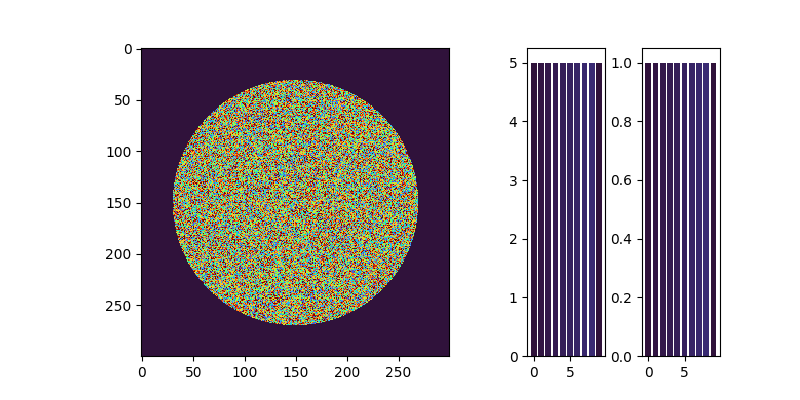

In [32]:
%matplotlib ipympl
from scipy.signal import fftconvolve
from scipy.signal import oaconvolve
convFunc = fftconvolve
timerPresicion = 4
filtersNWSE = [ # replicate from that direction
    [[0,0,0],[0,0,0],[0,1,0]], # N
    [[0,0,0],[1,0,0],[0,0,0]], # E
     [[0,1,0],[0,0,0],[0,0,0]], # S
    [[0,0,0],[0,0,1],[0,0,0]], # W
]
filtersNWSE = np.array(filtersNWSE)

filtersBoost = [
    [[1,0,1],
     [1,0,1],
     [0,0,0]], # N
    [[1,1,0],
     [0,0,0],
     [1,1,0]], # W
    [[0,0,0],
     [1,0,1],
     [1,0,1]], # S
    [[0,1,1],
     [0,0,0],
     [0,1,1]], # E
]
filtersBoost = np.array(filtersBoost)

N = 300

pDeath = 0.2
wDead = 11
wRepl = 1
wBoost = 100


nSpecies = 9
cmap = "turbo"
my_cmap = plt.get_cmap(cmap)
colors = my_cmap(np.arange(0,nSpecies)) 
# colors =  [
#         "#ffcdfd",
#         "#cd78bd",
#         "#923e80",
#         "#401b36",
#         "#191513",
#         "#293715",
#         "#527226",
#         "#7fae47",
#         "#befda5"
#       ]
# colors =  [
#         "#65024b",
#         "#a6428c",
#         "#d17fbc",
#         "#edc6e3",
#         "#f6f2f1",
#         "#d7e7c0",
#         "#8ab363",
#         "#4a7f2e",
#         "#0c4b00"
#       ]
# colors = [
#         "#192659",
#         "#4c588c",
#         "#8390c3",
#         "#bcc9f4",
#         "#194c00",
#         "#63640a",
#         "#aa9050",
#         "#eec99d",
#         "#fdfde6"
#       ]
# colors = [
#         "#e6e6ff",
#         "#91a7cd",
#         "#416a97",
#         "#15324f",
#         "#161819",
#         "#444029",
#         "#817a4e",
#         "#c3bc89",
#         "#ffffd9"
#       ]

# cmap = ListedColormap(colors)
speciesIds = np.arange(nSpecies+1, dtype = int)

lattice = np.zeros((nSpecies+1,N,N), dtype = int)
initDistribution = np.random.choice(speciesIds[1:], size = N*N)
initLattice = initDistribution.reshape(N,N)


Rsq = N**2/2/np.pi 
seedIs = []
seedJs = []
for i in range(N):
    for j in range(N):
        if (N/2 - i)**2 + (N/2 - j)**2 > Rsq:
            seedIs.append(i)
            seedJs.append(j)

initLattice[seedIs,seedJs] = 0 
newLattice = np.zeros((nSpecies+1, N, N), dtype = int) # init global


for s in range(1,nSpecies+1):
    lattice[s][initLattice == s] = 1




fig, ax = plt.subplots(1,3,figsize = (8,4),
                       dpi = 100,
                       #subplot_kw={'projection': 'polar'},
    gridspec_kw=dict(width_ratios=[5, 1, 1], 
                     wspace=0.2)
                      )

im=ax[0].imshow(initLattice, 
                interpolation='none', 
              #cmap = "Blues"
              cmap = cmap
             )
im2=ax[1].bar(x = range(nSpecies + 1), height = [5]*(nSpecies+1), color = colors)
im3=ax[2].bar(x = range(nSpecies + 1), height = [1]*(nSpecies+1), color = colors)



def init():
    im1 = plt.imshow(np.zeros(N,N))
    im2 = plt.bar(x = range(nSpecies + 1), height = [5]*(nSpecies+1), color = colors)
    return [im1, im2]

def animate(i):
    global lattice
    global latticeFlat

    timers = {}

    latticeFlat = (lattice * speciesIds[:,None,None]).sum(axis = 0)
    emptyCells = latticeFlat == 0
    fullCells = latticeFlat != 0
    r = np.random.random((N,N))
   # r = np.ones((N,N)) # tmp

    survivorIds = np.bitwise_and(fullCells, (r >= pDeath))
    diedIds = np.bitwise_and(fullCells, (r < pDeath))
    ############################
    # get claims
    ############################
    start = time.time()

    # replication claims
    claims = np.zeros((nSpecies+1,N,N))
    claims[0] = wDead
    claimIters = []
    for s in range(1, nSpecies + 1):
        sBoost = s - 1
        if sBoost == 0: sBoost = nSpecies # dead don't boost
            
        start2 = time.time()

        for fNWSE, fBoost in zip(filtersNWSE, filtersBoost):
            tmpClaim = convFunc(lattice[s], fNWSE, # get replication from the specific direction
                                  mode = "same", 
                                  boundary = "wrap")
            claims[s] += wRepl * tmpClaim
            allBoosts = convFunc(lattice[sBoost], fBoost, # count boosts in all cells
                                   mode = "same", 
                                   boundary = "wrap")
            claims[s] += wBoost * (allBoosts * tmpClaim) # apply boosts only to potentially replicated cells
            
        stop2 = time.time()
    claimIters.append(stop2 - start2)
    
    
    stop = time.time()
    timers["claims"] = np.round(stop - start, timerPresicion)
    timers["claim iter"] = np.round(np.mean(claimIters),timerPresicion)

    # sample along species axis
    start = time.time()
    
    cumClaims = np.cumsum(claims / claims.sum(axis=0), axis=0)
    rand = np.random.random((N,N))
    newLatticeFlat = np.argmax(cumClaims >= rand, axis=0)

    # put everything together
    newLatticeFlat[survivorIds] = latticeFlat[survivorIds] # survivors shouldn't have been claimed
   # newLatticeFlat[diedIds] = 0 # those died off

    newLattice = np.zeros((nSpecies+1, N, N), dtype = int)    
    for s in range(1, nSpecies+1):
        newLattice[s][newLatticeFlat == s] = 1   
    lattice = newLattice.copy()
    stop = time.time()
    timers["combine"] = np.round(stop - start, timerPresicion)
    ############################
    # plotting
    ############################
    start = time.time()

    im.set_array(newLatticeFlat)
    
    ccc = Counter(newLatticeFlat.flatten())
    for s in range(nSpecies+1):
        if not s in ccc:
            ccc[s] = 0
        
    vvv = [v for k,v in sorted([(k,v) for k,v in ccc.items()])]
    for rect, h in zip(im2, vvv):
        rect.set_height(h)
    ax[1].set_ylim(0, 1.05*max(vvv))
    stop = time.time()
    ax[0].set_title(timers)
    return [im,im2,im3]

ani = FuncAnimation(fig, animate, frames=20000, interval=15, save_count = 5,
                    cache_frame_data = True,
                    blit=False
                   )
#plt.show()
#from IPython.display import HTML

#HTML(ani.to_html5_video())

In [91]:
%matplotlib notebook
timerPresicion = 5
filtersNWSE = [ # replicate from that direction
    [[0,0,0],[0,0,0],[0,1,0]], # N
    [[0,0,0],[1,0,0],[0,0,0]], # E
     [[0,1,0],[0,0,0],[0,0,0]], # S
    [[0,0,0],[0,0,1],[0,0,0]], # W
]

filtersBoost = [
    [[1,0,1],
     [1,0,1],
     [0,0,0]], # N
    [[1,1,0],
     [0,0,0],
     [1,1,0]], # W
    [[0,0,0],
     [1,0,1],
     [1,0,1]], # S
    [[0,1,1],
     [0,0,0],
     [0,1,1]], # E
]
N = 300

pDeath = 0.5
wDead = 5
wRepl = 5
wBoost = 100
nSteps = 50

nSpecies = 7

speciesIds = np.arange(nSpecies+1, dtype = int)

lattice = np.zeros((nSpecies+1,N,N), dtype = int)
initDistribution = np.random.choice(speciesIds[1:], size = N*N)
initLattice = initDistribution.reshape(N,N)


Rsq = N**2/2/np.pi 
seedIs = []
seedJs = []
for i in range(N):
    for j in range(N):
        if (N/2 - i)**2 + (N/2 - j)**2 > Rsq:
            seedIs.append(i)
            seedJs.append(j)

initLattice[seedIs,seedJs] = 0 
newLattice = np.zeros((nSpecies+1, N, N), dtype = int) # init global


for s in range(1,nSpecies+1):
    lattice[s][initLattice == s] = 1

for step in range(nSteps):
    timers = {}
    start = time.time()

    latticeFlat = (lattice * speciesIds[:, None, None]).sum(axis=0)
    r = np.random.random((N, N))

    survivorIds = (latticeFlat != 0) & (r >= pDeath)
    diedIds = (latticeFlat != 0) & (r < pDeath)

    # Replication claims
    claims = np.zeros((nSpecies+1, N, N))
    claims[0] = wDead
    for s in range(1, nSpecies+1):
        sBoost = nSpecies if s == 1 else s - 1

        for fNWSE, fBoost in zip(filtersNWSE, filtersBoost):
            tmpClaim = convolve2d(lattice[s], fNWSE, mode="same", boundary="wrap")
            claims[s] += wRepl * tmpClaim

            allBoosts = convolve2d(lattice[sBoost], fBoost, mode="same", boundary="wrap")
            claims[s] += wBoost * (allBoosts * tmpClaim)
    
    # Sample along species axis
    cumClaims = np.cumsum(claims / claims.sum(axis=0), axis=0)
    rand = np.random.random((N, N))
    newLatticeFlat = np.argmax(cumClaims >= rand, axis=0)

    # Combine results
    newLatticeFlat[survivorIds] = latticeFlat[survivorIds]
    newLatticeFlat[diedIds] = 0

    newLattice = np.zeros((nSpecies+1, N, N), dtype=int)
    newLattice[np.arange(1, nSpecies+1)[:, None, None], 
               newLatticeFlat[None, :, :] == np.arange(1, nSpecies+1)[:, None, None]] = 1
    lattice = newLattice.copy()
    
    timer = np.round(stop - start, 3)
    print(timer)



IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [325]:
nSpecies = 2
speciesIds = np.arange( nSpecies+1)
N = 4
wBoost = 10
newLattice = np.zeros((nSpecies+1, N, N))

# species 1
newLattice[1,0,1] = 1
newLattice[1,1,2] = 1

# species 2
newLattice[2,0,2] = 1
lattice = newLattice.copy()



In [320]:
lattice

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [250]:
nwseFilter = np.array([[0,1,0],[1,0,1],[0,1,0]])






# replication claims
claims = np.zeros((nSpecies+1,N,N))
claims[0] = wDead

for s in range(1, nSpecies + 1):
    claims[s] += wRepl * convolve2d(lattice[s], nwseFilter, mode = "same", boundary = "wrap")
finalClaims = claims.copy()

# boosted claims
boostedClaims = np.zeros((nSpecies+1,N,N))

for s in range(1, nSpecies + 1):
    sBoost = s-1
    if sBoost == 0: sBoost = nSpecies
    for fNWSE, fBoost in zip(filtersNWSE,filtersBoost):

        # this gives 1's where the cell replicated from the given direction (NWSE)
        tmpClaim = convolve2d(lattice[s], fNWSE, # get replication from the specific direction
                              mode = "same", 
                              boundary = "wrap")
        
        finalClaims[s] += wBoost * (convolve2d(lattice[sBoost], fBoost, mode = "same", boundary = "wrap") * tmpClaim )
        
# sample along species axis
cumClaims = np.cumsum(finalClaims / finalClaims.sum(axis=0), axis=0)
rand = np.random.random((N,N))
latticeFlat = np.argmax(cumClaims >= rand, axis=0)
 


In [248]:
aaa

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35]])

In [247]:
asd * aaa

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  9., 10.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 21., 22.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [249]:
asd

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [214]:
finalClaims

array([[[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]],

       [[21., 20., 42., 20.],
        [20., 42., 20., 21.],
        [ 0., 20., 21., 20.],
        [20., 21., 20.,  0.]],

       [[ 0., 21.,  0., 21.],
        [ 0., 20., 21., 20.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 20., 21., 20.]]])

In [210]:
np.argmax(cumClaims >= rand, a
         )

0

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True, False,  True]])

In [122]:
nSpecies = 2
speciesIds = np.arange( nSpecies+1)
N = 4
wBoost = 10
wDead = 11
newLattice = np.zeros((nSpecies+1, N, N))

# species 1
newLattice[1,0,1] = 1
newLattice[1,1,2] = 1

# species 2
newLattice[2,0,2] = 1
lattice = newLattice.copy()
print("lattice init")
print(lattice)

latticeFlat = (lattice * speciesIds[:,None,None]).sum(axis = 0)
emptyCells = latticeFlat == 0
print("latticeFlat")
print(latticeFlat)
r = np.random.random((N,N))
#r = np.ones((N,N)) # tmp

survivorIds = r >= pDeath
#survivorIds = []
diedIds = (r < pDeath) == survivorIds
print("died")
print(diedIds)

############################
# get claims
############################

# replication claims
claims = np.zeros((nSpecies+1,N,N))
claims[0] = wDead

# boosted claims
boostedClaims = np.zeros((nSpecies+1,N,N))

for s in range(1, nSpecies + 1):
    sBoost = s - 1
    if sBoost == 0: sBoost = nSpecies # dead don't boost
    for fNWSE, fBoost in zip(filtersNWSE, filtersBoost):
        tmpClaim = convolve2d(lattice[s], fNWSE, # get replication from the specific direction
                              mode = "same", 
                              boundary = "wrap")
        claims[s] += wRepl * tmpClaim

claimsBoost = np.zeros((nSpecies+1,N,N))
for s in range(1, nSpecies + 1):
    sBoost = s - 1
    if sBoost == 0: sBoost = nSpecies # dead don't boost
    for fNWSE, fBoost in zip(filtersNWSE, filtersBoost):
        tmpClaim = convolve2d(lattice[s], fNWSE, # get replication from the specific direction
                              mode = "same", 
                              boundary = "wrap")
        allBoosts = convolve2d(lattice[sBoost], fBoost, # count boosts in all cells
                               mode = "same", 
                               boundary = "wrap")
        claimsBoost[s] += wBoost * (allBoosts * tmpClaim) # apply boosts only to potentially replicated cells

print("claims")
print(claims)
print("claimsBoost")
print(claimsBoost)
print("claimsTotal")
claimsTotal = claims + claimsBoost
print(claimsTotal)
# sample along species axis
cumClaims = np.cumsum(claimsTotal / claimsTotal.sum(axis=0), axis=0)
#cumClaims = np.cumsum(claims , axis=0)
print("cumClaims")
print(cumClaims)
rand = np.random.random((N,N))
print("rand")
print(rand)

newLatticeFlat = np.argmax(cumClaims >= rand, axis=0)
print("newLatticeFlat")
print(newLatticeFlat)
# put everything together
#newLatticeFlat[survivorIds] = latticeFlat[survivorIds] # survivors shouldn't have been claimed
#newLatticeFlat[diedIds] = 0 # those died off

newLattice = np.zeros((nSpecies+1, N, N), dtype = int)    
for s in range(1, nSpecies+1):
    newLattice[s][newLatticeFlat == s] = 1   
lattice = newLattice.copy()
print(lattice)

lattice init
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
latticeFlat
[[0. 1. 2. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
died
[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
claims
[[[11. 11. 11. 11.]
  [11. 11. 11. 11.]
  [11. 11. 11. 11.]
  [11. 11. 11. 11.]]

 [[ 1.  0.  2.  0.]
  [ 0.  2.  0.  1.]
  [ 0.  0.  1.  0.]
  [ 0.  1.  0.  0.]]

 [[ 0.  1.  0.  1.]
  [ 0.  0.  1.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  1.  0.]]]
claimsBoost
[[[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0. 10.  0. 10.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0. 10.  0. 10.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]]
claimsTotal
[[[11. 11. 11. 11.]
  [11. 11. 11. 11.]
  [11. 11. 11. 11.]
  [11. 11. 11. 11.]

array([[False, False, False, False],
       [False, False,  True, False],
       [False, False, False, False],
       [False, False, False, False]])

In [47]:
fullCells 

array([[False,  True,  True, False],
       [False, False,  True, False],
       [False, False, False, False],
       [False, False, False, False]])

In [48]:
(r < pDeath)

array([[ True, False, False,  True],
       [False,  True,  True,  True],
       [ True, False, False, False],
       [False, False, False, False]])

In [49]:
np.bitwise_and(fullCells, (r < pDeath))

array([[False, False, False, False],
       [False, False,  True, False],
       [False, False, False, False],
       [False, False, False, False]])

array([[False,  True,  True, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False]])